<h1><center>Práctica Donativos Veterano de Guerra<center><h1>

# Integrantes

Sofía Maceín Sanz, María Araceli Pérez Buendía.

Fecha de entrega: 23 de febrero de 2024

# 0. Librerías

In [1]:
# Paquetes y librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip install graphviz


En primer lugar, obtenemos los datos del análisis exploratorio hecho previamente, habiendo separado los datos en un conjunto de entrenamiento y de test.

In [3]:
# Importacion de datos
X_train = pd.read_csv('./Datos/X_train.csv')
X_val = pd.read_csv('./Datos/X_val.csv')
X_test = pd.read_csv('./Datos/X_test.csv')
y_train = pd.read_csv('./Datos/y_train.csv')
y_val = pd.read_csv('./Datos/y_val.csv')
y_test = pd.read_csv('./Datos/y_test.csv')

In [4]:
# Para ajustar el final
X_profe = pd.read_csv('./Datos/X_profe.csv')
control = pd.read_csv('./Datos/control.csv')

## Funciones auxiliares

In [5]:
# Funcion para crear el modelo 
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Funcion para mostrar los resultados
def mostrar_resultados2(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels='x', yticklabels='y', annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    print(classification_report(y_test, pred_y))
    
    # Calcular el AUC
    auc = roc_auc_score(y_test, pred_y)
    print("AUC:", auc)
    
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, pred_y)
    
    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 3. Modelos

## Métricas


Para evaluar los modelos

In [ ]:
# Definir diccionarios con las metricas

## 3.1 Árbol de decisión

Es importante comprender que los árboles de decisión son algoritmos que **no requieren demasiada preparación de los datos** concretamente, no requieren la realización de escalado o normalización. En este ejercicio se va a realizar escalado al conjunto de datos y se van a comparar los resultados con el conjunto de datos sin escalar. De esta forma se demuestra como aplicar preprocesamientos como el escalado puede incluso llegar a afectar al rendimiento del modelo.

In [6]:
# Librerias
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

Como desconocemos la profundidad óptima para discriminar bien los datos, realizamos una hiperparametrización sobre la misma. Además, miramos también qué criterio puede funcionar mejor.

Utilizamos siempre `class_weight`= 'balanced' para tratar el desbalanceo de los datos. Además, para comparar los modelos usamos `random_state`=42.

* **GridSearch**: Realiza una búsqueda exhaustiva en un conjunto predefinido de valores de hiperparámetros. Básicamente, crea un "grid" o "rejilla" de combinaciones posibles de valores de hiperparámetros y prueba cada combinación.

* **CV (Cross-Validation)**: Utiliza validación cruzada para evaluar el rendimiento de cada combinación de hiperparámetros. La validación cruzada ayuda a estimar el rendimiento del modelo de manera más precisa al dividir el conjunto de datos en varios "pliegues" (folds) y entrenar y evaluar el modelo en múltiples combinaciones de datos de entrenamiento y prueba.

* Por lo tanto, al especificar **scoring='roc_auc'** en GridSearchCV, se busca la combinación de hiperparámetros que maximice el área bajo la curva ROC durante la búsqueda de grid. 

In [20]:
# Hiperparametros a ajustar
param_grid = {
    'max_depth': list(range(1, 10)),
    'criterion': ['gini', 'entropy']
}

# Instanciar el modelo
tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Busqueda de hiperparametros
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, refit=True)
# scoring = roc_auc : Tratamos de maximizar area bajo la curva roc
# cv = 5: cross validation con k-flods = 5
grid_search.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Resultados
results = grid_search.cv_results_

# Recopilar los AUC-ROC de cada modelo probado
auc_scores = results['mean_test_score']

# Obtener los mejores hiperparámetros y la mejor puntuación
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación AUC-ROC:", best_score)

# Imprimir los AUC-ROC de cada modelo probado
print("\nAUC-ROC de cada modelo probado:")
for params, score in zip(results['params'], auc_scores):
    print(params, "-", score)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 5}
Mejor puntuación AUC-ROC: 0.5952826494051623

AUC-ROC de cada modelo probado:
{'criterion': 'gini', 'max_depth': 1} - 0.5592096831304622
{'criterion': 'gini', 'max_depth': 2} - 0.5797530383090692
{'criterion': 'gini', 'max_depth': 3} - 0.5879555774067905
{'criterion': 'gini', 'max_depth': 4} - 0.5934424110114301
{'criterion': 'gini', 'max_depth': 5} - 0.5865102886895501
{'criterion': 'gini', 'max_depth': 6} - 0.5811111324796902
{'criterion': 'gini', 'max_depth': 7} - 0.5754090972141219
{'criterion': 'gini', 'max_depth': 8} - 0.5647537712345025
{'criterion': 'gini', 'max_depth': 9} - 0.5605533734126149
{'criterion': 'entropy', 'max_depth': 1} - 0.5592096831304622
{'criterion': 'entropy', 'max_depth': 2} - 0.587054753207479
{'criterion': 'entropy', 'max_depth': 3} - 0.5921688174321684
{'criterion': 'entropy', 'max_depth': 4} - 0.5945775770852377
{'criterion': 'entropy', 'max_depth': 5} - 0.5952826494051623
{'criterion': 'e

Ajustamos el modelo con los hiperparámetros propuestos

In [21]:
# Ajuste del modelo
arbol = DecisionTreeClassifier(class_weight='balanced', max_depth=5, criterion='entropy', random_state=42)
arbol.fit(pd.concat([X_train, X_val]),pd.concat([y_train, y_val]))

# Predicciones
y_pred_arbol = arbol.predict(X_test)

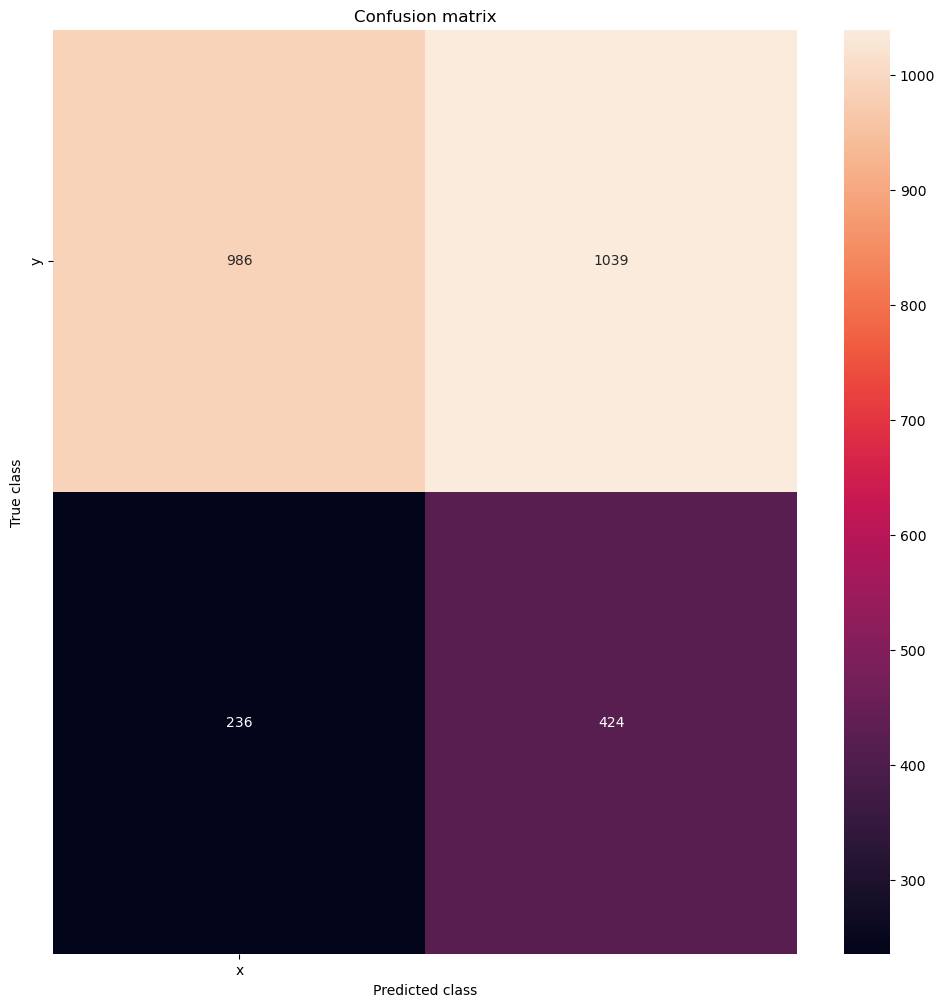

              precision    recall  f1-score   support

           0       0.81      0.49      0.61      2025
           1       0.29      0.64      0.40       660

    accuracy                           0.53      2685
   macro avg       0.55      0.56      0.50      2685
weighted avg       0.68      0.53      0.56      2685

AUC: 0.5646689113355781


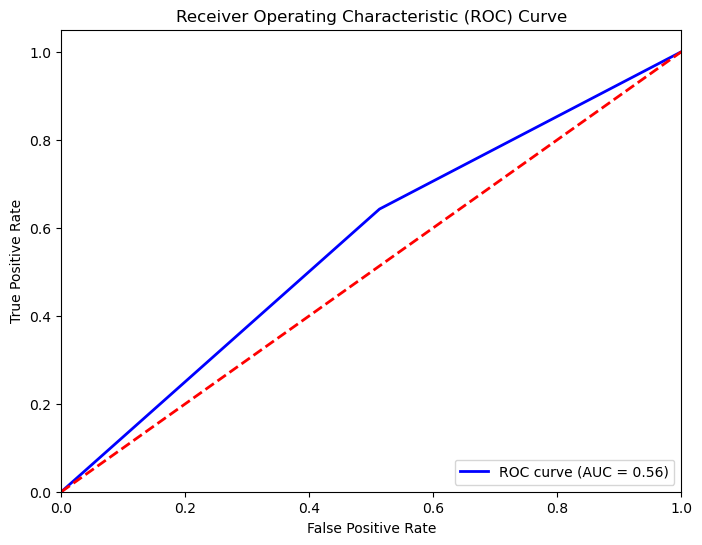

In [22]:
# Metricas con el test
mostrar_resultados2(y_test, y_pred_arbol)

In [ ]:
# Grafico
plt.figure(figsize=(50,20))
tree.plot_tree(arbol)
plt.show()

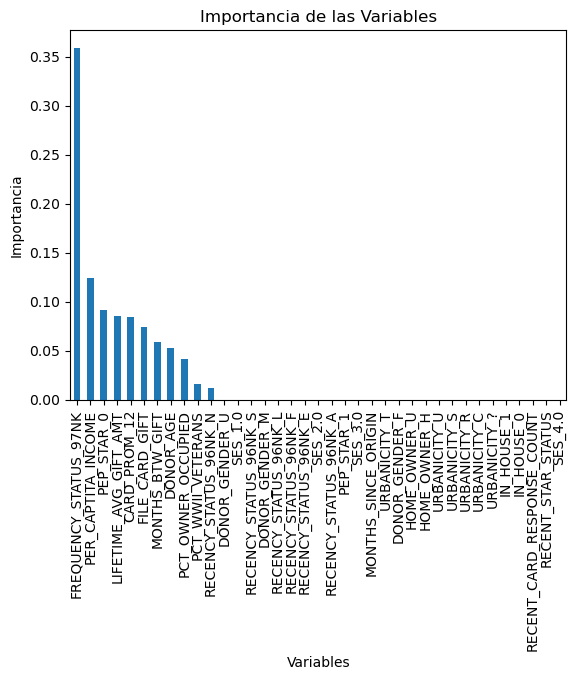

In [23]:
# Importancia de las variables
feature_importances = pd.Series(arbol.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar')

plt.title('Importancia de las Variables')
plt.xlabel('Variables')
plt.ylabel('Importancia')

plt.show()

**Con TABLA PROFE**

In [24]:
# Predicciones
profe_y_pred_arbol = arbol.predict(X_profe)

## 3.2 Regresión Logística

In [25]:
from sklearn.linear_model import LogisticRegression

* **L1 Penalty (Lasso)**: En esta penalización, la función de costo se modifica agregando la norma L1 de los coeficientes del modelo. Esto significa que se agrega la suma de los valores absolutos de los coeficientes multiplicados por un término de penalización a la función de costo. La penalización L1 tiende a generar modelos dispersos donde muchos de los coeficientes son exactamente cero, lo que puede ser útil para la selección de características.

* **L2 Penalty (Ridge)**: En esta penalización, la función de costo se modifica agregando la norma L2 (cuadrado de la magnitud) de los coeficientes del modelo. Esto significa que se agrega la suma de los cuadrados de los coeficientes multiplicados por un término de penalización a la función de costo. La penalización L2 tiende a suavizar los coeficientes y evitar que tomen valores extremadamente grandes.

* Los **parámetros de regularización**, como **C** en la regresión logística, controlan la fuerza de la penalización. C es el inverso del parámetro de regularización, por lo que valores más pequeños de C indican una mayor regularización y valores más grandes indican menos regularización. Específicamente, C controla la magnitud de la penalización: un valor más grande de C significa una penalización más débil, lo que permite que el modelo ajuste los datos de entrenamiento de manera más ajustada (menos regularización), mientras que un valor más pequeño de C significa una penalización más fuerte, lo que limita el ajuste del modelo (más regularización). En resumen, C controla el equilibrio entre ajuste de datos y generalización en la regresión logística.

* Solver **'saga'**: Similar a 'sag', 'saga' también utiliza el método de promedio de gradientes estocásticos para optimizar la función de costo. Sin embargo, 'saga' es una extensión de 'sag' que admite la penalización L1 y L2, lo que lo hace útil cuando se desea regularización L1 en grandes conjuntos de datos.

In [26]:
# Definir los parámetros a ajustar
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Inicializar el modelo de regresión logística
lr = LogisticRegression(penalty='l2', random_state=42, solver='newton-cg', class_weight='balanced')

# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Ajustar la búsqueda en cuadrícula a los datos
grid_search.fit(X_train, y_train)

# Obtener los resultados de la búsqueda
results = grid_search.cv_results_

# Recopilar los AUC de cada modelo probado
auc_scores = results['mean_test_score']

# Obtener el mejor modelo y sus hiperparámetros
best_lr = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluar el modelo en el conjunto de validación
y_pred_proba = best_lr.predict_proba(X_val)[:, 1]
best_model_auc = roc_auc_score(y_val, y_pred_proba)

print("Mejores hiperparámetros:", best_params)
print("AUC en el conjunto de validación:", best_model_auc)

# Imprimir los AUC de cada modelo probado
print("\nAUC de cada modelo probado:")
for params, score in zip(results['params'], auc_scores):
    print(params, "-", score)

Mejores hiperparámetros: {'C': 0.001}
AUC en el conjunto de validación: 0.6297429738956003

AUC de cada modelo probado:
{'C': 0.001} - 0.607390076292108
{'C': 0.01} - 0.6068708479823833
{'C': 0.1} - 0.6051333847390549
{'C': 1} - 0.604470437813071
{'C': 10} - 0.60440826102181
{'C': 100} - 0.6043732811901688


In [ ]:
# Ajustamos el modelo
lr = LogisticRegression(C=0.001,penalty='l2',random_state=42,solver="newton-cg",class_weight="balanced")
lr.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predicciones
# Evaluar el modelo en el conjunto de prueba
y_pred_lr = lr.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_lr)
auc

In [ ]:
# Calcular y mostrar las métricas
y_pred_lr_2 = lr.predict(X_test)
mostrar_resultados2(y_test, y_pred_lr_2)

**Con TABLA PROFE**

In [ ]:
# Predicciones
profe_y_pred_lr = lr.predict_proba(X_profe)[:, 1]
profe_y_pred_lr_2 = lr.predict(X_profe)

## 2.3 Random Forest

Se trata de un modelo de ensamble que combia varios árboles de decisión para hacer predicciones. Así, cada árbol de decisión es entrenado en un subconjunto de los datos de entrenamiento elegido de manera aleatoria, lo que ayuda a reducir el problema de overfitting (o sobreajuste). Las predicciones se realizan teniendo en cuenta la clasificación mayoritaria de las predicciones de cada árbol individual.

Se trata de un tipo específico de método de Bagging, pues además de usar muestras bootstrap de los datos de entrenamiento, cada árbol se entrena en un subconjunto aleatorio de características.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

En este caso, podemos utilizar técnicas de cross validation para hallar:

* **n_estimators**: Es el número de árboles de decisión para el Random Forest. En general, un mayor número de estimadores mejora el rendimiento del modelo, pero también incrementa el costo computacional para realizar predicciones.
* **max_depth**: Es la profundidad del árbol. Una profundidad alta puede llevar a overfitting, mientras que una profundidad baja puede resultar en underfitting.

Utilizando técnicas de validación cruzada, podemos ajustar estos hiperparámetros y seleccionar los valores óptimos que maximicen el rendimiento del modelo. En este caso, vamos a utilizar la función RandomizedSearch()

In [ ]:
# Definir el rango de profundidades y número de árboles
ps = np.array(range(50, 250))  # profundidades
ns = np.array(range(1, 10))    # n árboles

# Definir los hiperparámetros, incluyendo el criterio
h_parameters = {'n_estimators': ps,
                'max_depth': ns,
                'criterion': ['gini', 'entropy']}

# Instanciar el modelo
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# Definir las métricas a utilizar para la búsqueda
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}

# Realizar la hiperparametrización
rand_search = RandomizedSearchCV(rf, param_distributions=h_parameters, n_iter=5, cv=5, scoring=scoring, refit='AUC', n_jobs=-1)
rand_search.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Obtener el mejor modelo
best_rf = rand_search.best_estimator_

# Mostrar los mejores hiperparámetros
print('Mejores hiperparámetros:', rand_search.best_params_)

In [ ]:
# Obtener el AUC obtenido
auc_score = rand_search.best_score_

# Imprimir el AUC obtenido
print('AUC obtenido:', auc_score)

Con los parámetros determinados, ajustamos el modelo.

In [ ]:
# Ajuste del modelo
rf = RandomForestClassifier(class_weight='balanced', n_estimators = 100, max_depth=5, criterion='entropy', random_state=42, n_jobs = -1)
rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predicciones
y_pred_forest = rf.predict(X_test)

In [ ]:
# Calcular y mostrar las métricas
mostrar_resultados2(y_test, y_pred_forest)

**Con TABLA PROFE**

In [ ]:
# Predicciones
profe_y_pred_forest = rf.predict(X_profe)

## 2.4 Gradient Boosting

Gradient boostig es un algoritmo de machine learning que se basa en la creación de un conjunto de modelos de predicción débiles, generalmente árboles de decisión, que se combinan para formar un modelo de predicción más fuerte. En cada iteración, el algoritmo ajusta los pesos de los modelos débiles para corregir los errores del modelo anterior. Esto se hace mediante la optimización de una función de pérdida diferenciable.

In [ ]:
# Librerias
from sklearn.ensemble import GradientBoostingClassifier

En primer lugar, buscamos los hiperparámetros del modelo de la misma forma que lo hemos hecho para el modelo de Random Forest.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
import numpy as np

# Posibles profundidades y numero de arboles
ps = np.array(range(50, 250))  # profundidades
ns = np.array(range(3, 10))   # n arboles

h_parameters = {'n_estimators': ps, 'max_depth': ns, 'subsample': [0.8, 0.9, 1.0], 'learning_rate': [0.01, 0.1, 0.5, 1.0]}

# Instanciar el modelo
gb = GradientBoostingClassifier()

# Definir las métricas a utilizar para la búsqueda
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}

# Realizar la hiperparametrización
rand_search = RandomizedSearchCV(gb, param_distributions=h_parameters, n_iter=5, cv=5, scoring=scoring, refit='AUC')
rand_search.fit(X_train, y_train)

# Optimo
best_gb = rand_search.best_estimator_
print('Mejores hiperparámetros:', rand_search.best_params_)


In [ ]:
best_gb

In [ ]:
# Ajustar el modelo con los datos de entrenamiento
best_gb.fit(X_train, y_train)

# Hacer predicciones en los datos de validación
y_pred_gb = best_gb.predict(X_test)

# Calcular métricas de evaluación
mostrar_resultados2(y_test, y_pred_gb)


**Con TABLA PROFE**

In [ ]:
# Predicciones
profe_y_pred_gb = best_gb.predict(X_profe)

# TABLA FINAL

In [ ]:
control['CONTROL_NUMBER_N']

In [ ]:
tabla = {
    'Control': control['CONTROL_NUMBER_N'],
    'Arbol': profe_y_pred_arbol,
    'Regresion Log': profe_y_pred_lr_2,
    'Random Forest': profe_y_pred_forest,
    'Gradient_Boosting': profe_y_pred_gb
}

# Crear el DataFrame
resultados = pd.DataFrame(tabla)

# Mostrar el DataFrame
print(resultados)